# Project 1 Neural Processing of Emotionally Provocative Auditory Stimuli
Group AC - Nils, Alexis, Ameer, and Katla

# Part 1

In [1]:
%gui wx
import sys
import os

notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist

Gtk-Message: 15:48:30.351: Failed to load module "canberra-gtk-module"


#### Imports

In [2]:
os.environ["DIPY_HOME"] = "/home/jovyan/Data"

import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

loadFSL()

import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm

# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

In [ ]:
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

## 1.0 Downloading Data

In [4]:
dataset_id = 'ds000171'
subject = 'control01' 

sample_path = "/home/jovyan/Data/dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)

#download dataset

#subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, # Openneuro has for each dataset a unique identifier
#                "--target-dir", bids_root,  # The path where we want to save our data. You should save your data under /home/jovyan/Data/[your dataset ID] to be 100% fool-proof
#                "--include", subject_dir # Effectively get all data
#               ], check=True)
###################
# Create folders relevant for preprocessing.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-control01'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'func'))

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))

In [ ]:
print_dir_tree(bids_root, max_depth=5)

## Part 1.1 Preprocessing

### 1.1.A.1 Brain Extraction

In [7]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """

    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "control01", robust=True)

Done with BET.


#### Observing the resulting mask

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))
fsleyesDisplay.load(resulting_mask_path)

#### Manually Improving the Fit before applying the mask
Manually done on FSL 

In [8]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):

    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask.nii.gz') # The mask to use

# Applying the mask
apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

#### Quality Check

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

In [ ]:
print_dir_tree(bids_root, max_depth=5)

### 1.1.A.2 Coregistration fMRI to Anatomical

#### Step 1: Align Anatomical Mask to One Volume of the fMRI Runs
Selecting an "Anchor" reference fMRI volume for aligning the anatomical brain mask to the fMRI space

In [9]:
# Step 1: Align Anatomical Mask to One Volume of the fMRI Runs
fmri_run_path = op.join(bids_root,'sub-control01', 'func', 'sub-control01_task-music_run-1_bold.nii.gz')
processing_path = op.join(preproc_root, 'sub-control01', 'func', 'reference_volume.nii.gz')

# Use the middle frame index as the reference volume
img = nib.load(fmri_run_path)
fmri_data_1 = img.get_fdata()
reference_frame = int(fmri_data_1.shape[3]/2)
subprocess.run(["fslroi", fmri_run_path, processing_path, str(reference_frame), "1"], check=True)

CompletedProcess(args=['fslroi', '/home/jovyan/Data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/reference_volume.nii.gz', '52', '1'], returncode=0)

#### Step 2: Coregister the Anatomical Image to the Reference fMRI Volume
Aligning the anatomical image to the reference volume

In [10]:
# Step 2: Coregister the Anatomical Image to the Reference fMRI Volume
anatomical_path = op.join(bids_root,'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')
coregistered_path = op.join(preproc_root, 'sub-control01', 'anat')
# Running flirt with mutual info cost function
subprocess.run([
    "flirt", "-in", anatomical_path, "-ref", processing_path,
    "-out", op.join(coregistered_path,"coregistered_anatomical.nii.gz"), "-omat", op.join(coregistered_path,"anat2fmri.mat"),
    "-dof", "6", "-cost", "mutualinfo"
], check=True)

CompletedProcess(args=['flirt', '-in', '/home/jovyan/Data/dataset/ds000171/sub-control01/anat/sub-control01_T1w.nii.gz', '-ref', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/reference_volume.nii.gz', '-out', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/coregistered_anatomical.nii.gz', '-omat', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/anat2fmri.mat', '-dof', '6', '-cost', 'mutualinfo'], returncode=0)

#### Step 3: Apply the transformation to the Brain Mask

In [11]:
# Step 3: Apply Transformation to the Brain Mask
subprocess.run([
    "flirt", "-in", op.join(coregistered_path,"sub-control01_T1w_mask.nii.gz"), "-ref", processing_path,
    "-applyxfm", "-init", op.join(coregistered_path, "anat2fmri.mat"), "-out", op.join(coregistered_path,"aligned_brain_mask.nii.gz"),
    "-interp", "nearestneighbour"
], check=True)

CompletedProcess(args=['flirt', '-in', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_mask.nii.gz', '-ref', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/reference_volume.nii.gz', '-applyxfm', '-init', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/anat2fmri.mat', '-out', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/aligned_brain_mask.nii.gz', '-interp', 'nearestneighbour'], returncode=0)

#### Step 4: Applying the mask to every fMRI runs

In [14]:
# Step 4: Applying the mask to every fMRI runs
fmri_runs_path = op.join(bids_root,'sub-control01', 'func')
output_fmri_path = op.join(preproc_root, 'sub-control01', 'func')
# Apply mask to fMRI_run1
subprocess.run(["fslmaths", op.join(fmri_runs_path, 'sub-control01_task-music_run-1_bold.nii.gz'), "-mas", op.join(coregistered_path,"aligned_brain_mask.nii.gz"), op.join(output_fmri_path,"masked_fMRI_run1.nii.gz")], check=True)

# Apply mask to fMRI_run2
subprocess.run(["fslmaths", op.join(fmri_runs_path, 'sub-control01_task-music_run-2_bold.nii.gz'), "-mas", op.join(coregistered_path,"aligned_brain_mask.nii.gz"), op.join(output_fmri_path,"masked_fMRI_run2.nii.gz")], check=True)

# Apply mask to fMRI_run3
subprocess.run(["fslmaths", op.join(fmri_runs_path, 'sub-control01_task-music_run-3_bold.nii.gz'), "-mas", op.join(coregistered_path,"aligned_brain_mask.nii.gz"), op.join(output_fmri_path,"masked_fMRI_run3.nii.gz")], check=True)

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-3_bold.nii.gz', '-mas', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/aligned_brain_mask.nii.gz', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/masked_fMRI_run3.nii.gz'], returncode=0)

#### Quality Check of the Masked fMRI runs

In [15]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(output_fmri_path,"masked_fMRI_run3.nii.gz"))

## 1.1.B Standardizing & Concatenating Data
The standardization considers only non-zero values (brain region) to avoid considering background voxels

In [16]:
# Finding the runs matching the structure run-*
fmri_paths = glob.glob(op.join(output_fmri_path, 'masked_fMRI_run*.nii.gz'))
mask_path = op.join(coregistered_path,"aligned_brain_mask.nii.gz")  # Each run uses the same mask

# Load the brain mask and converting to boolean for masking
mask_img = nib.load(mask_path)
mask_data = mask_img.get_fdata().astype(bool)

# List to hold the standardized data arrays from each run
standardized_fmri_data = []

# Loop through each run file and load it
for i, run_path in enumerate(fmri_paths):
    
    # Extracting the data as a numpy array
    img = nib.load(run_path)
    data = img.get_fdata()  

    # Masking the data to include only the brain region
    brain_data = data[mask_data]

    # Computing the mean and std only within the brain region
    mean = np.mean(brain_data)
    std = np.std(brain_data)
    print("Standardizing run {} with mean: {} and std: {}".format(i+1, round(mean, 3), round(std, 3)))

    # Standardize within the brain region and set background to 0
    standardized_data = np.zeros_like(data)
    standardized_data[mask_data] = (brain_data - mean) / std

    # Append standardized data for concatenation
    standardized_fmri_data.append(standardized_data)

# Concatenate the standardized runs along the time dimension (4th dimension)
concatenated_data = np.concatenate(standardized_fmri_data, axis=3)

# Create a new NIfTI image for the concatenated data
concatenated_img = nib.Nifti1Image(concatenated_data, img.affine, img.header)

# Save the concatenated image
nib.save(concatenated_img, op.join(preproc_root, 'sub-control01', 'func', 'concatenated_bold.nii.gz'))
print("Concatenation complete and saved as concatenated_bold.nii.gz")

Standardizing run 1 with mean: 900.528 and std: 265.361
Standardizing run 2 with mean: 904.879 and std: 264.984
Standardizing run 3 with mean: 898.554 and std: 264.355
Concatenation complete and saved as concatenated_bold.nii.gz


#### Verification: the concatenated data should have mean = 0.0, std = 1.0

In [17]:
print("Resulting concatenated data has mean: {} and std: {}".format(round(np.mean(concatenated_data[mask_data]),3), round(np.std(concatenated_data[mask_data]),3)))

Resulting concatenated data has mean: 0.0 and std: 1.0


In [ ]:
print_dir_tree(bids_root, max_depth=5)

#### Quality Check

In [18]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, 'sub-control01', 'func', 'concatenated_bold.nii.gz'))

## 1.1.C Pre-processing Data

### 1.1.C.PP1 - Motion Correction

In [19]:
from fsl.wrappers import mcflirt

path_original_data = os.path.join(preproc_root, 'sub-control01', 'func','concatenated_bold.nii.gz')
path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [ ]:
print_dir_tree(bids_root, max_depth=5)

In [20]:
# Looking at the time series
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_moco_data)

#### Observing the motion correction parameters

In [21]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco.par'))

In [23]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere

    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

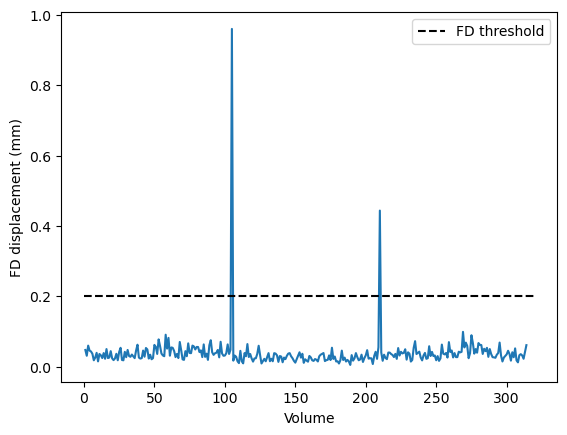

In [28]:
threshold = 0.2 # Threshold of 0.2 deemed sufficient

# Plotting
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 320,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.savefig(op.join(preproc_root,"FD_displacement.png"))
plt.show()

In [29]:
motion_artifacts = np.where(fd > threshold)[0] + 1
print(motion_artifacts)

[105 210]


### 1.1.C.PP2 - Smoothing

#### Step 1: Smoothing to 6 mm

In [30]:
output_path = op.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco')
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_bold_moco', '-s', '2.547987090198743', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_bold_moco_smoothed-6mm'], returncode=0)

#### Step 2: Applying the mask to set background voxels to 0

In [31]:
# Applying again a mask to remove the background post-smoothing
subprocess.run(["fslmaths", op.join(output_path + '_smoothed-6mm'), "-mas", op.join(coregistered_path,"aligned_brain_mask.nii.gz"), op.join(preproc_root, 'sub-control01', 'func',"pre-processed_fmri.nii.gz")], check=True)

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_bold_moco_smoothed-6mm', '-mas', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/aligned_brain_mask.nii.gz', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/pre-processed_fmri.nii.gz'], returncode=0)

#### Quality Check

In [32]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, 'sub-control01', 'func',"pre-processed_fmri.nii.gz"))

## Part 1.2 Experimental Design Matrix

#### Imports

In [91]:
# Importing relevant libraries
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_contrast_matrix
from nilearn.glm.first_level.design_matrix import _make_drift
from nilearn.image import mean_img
import nibabel as nib
import matplotlib.patches as mpatches
from nilearn import plotting
from nilearn.glm import threshold_stats_img

### 1.2.A Basic Design Matrix (Without drifts and outliers) 

In [35]:
df_run_1 = pd.read_csv(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_events.tsv'), sep='\t')
df_run_2 = pd.read_csv(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_events.tsv'), sep='\t')
df_run_3 = pd.read_csv(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-3_events.tsv'), sep='\t')

dfs = [df_run_1, df_run_2, df_run_3]
dataframes = []
offset = 0

for df in dfs:
    # Adjust onset times
    df['onset'] += offset
    
    # Append the adjusted dataframe
    dataframes.append(df)
    
    # Update offset for next run
    offset = df['onset'].iloc[-1] + df['duration'].iloc[-1]  # End of last event

# Concatenate all runs into one design matrix
df_concatenated = pd.concat(dataframes, ignore_index=True)

#### Step 1: Fit the GLM

In [38]:
fmri_img = op.join(preproc_root, 'sub-control01', 'func',"pre-processed_fmri.nii.gz")
fmri_glm = FirstLevelModel(t_r=3,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01,
                           mask_img = mask_img
                          )

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, df_concatenated)

#### Step 2: Plot the design matrix

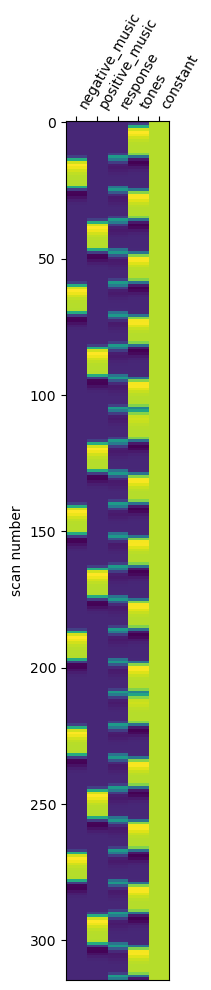

In [40]:
plot_design_matrix(fmri_glm.design_matrices_[0], rescale=False)
plt.show()

### 1.2.B Including Regressors in the Model

#### Including drift

In [73]:
# Creation of the drift model: Order 1-2-3
column_values, column_names = _make_drift(drift_model='polynomial', frame_times=np.asarray(list(range(0, 943, 3))), order=3, high_pass=None)

In [42]:
design_mat = fmri_glm.design_matrices_[0]
for (col, name) in zip(column_values.T, column_names):
    design_mat[name] = col

#### Including motion artifacts

In [44]:
design_mat_regged = design_mat.copy()
volumes_number = fd.size + 1 # Number of volume = timeseries
for i, volume in enumerate(motion_artifacts):
    reg = np.zeros((volumes_number,))*0.0
    reg[volume-1] = 1.0 # adding a regressor at the specific location of the artifact (-1 because we added +1 before)
    design_mat_regged['motion outlier#' + str(i+1)] = reg

#### Step 1: Fit the GLM

In [45]:
fit_glm = FirstLevelModel(t_r=3,
                           drift_model=None,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           high_pass=.01,
                           mask_img = mask_img
                         )

# Fit the model to our design and data
fit_glm = fit_glm.fit(fmri_img, design_matrices=[design_mat_regged] )

#### Step 2: Plot the design matrix

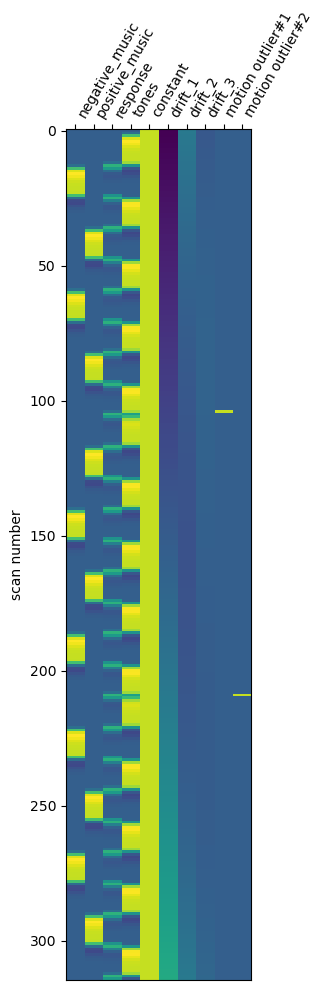

In [49]:
plot_design_matrix(design_mat_regged, rescale=False)#, output_file = op.join(bids_root, "design_matrix.png"))
plt.show()

## Part 1.3 Running the GLM at single-subject level

<p style="font-size:25px;">$$Y = X\beta + \epsilon$$</p>


### 1.3.A Beta/Statistical Maps

['negative_music', 'positive_music', 'response', 'tones']


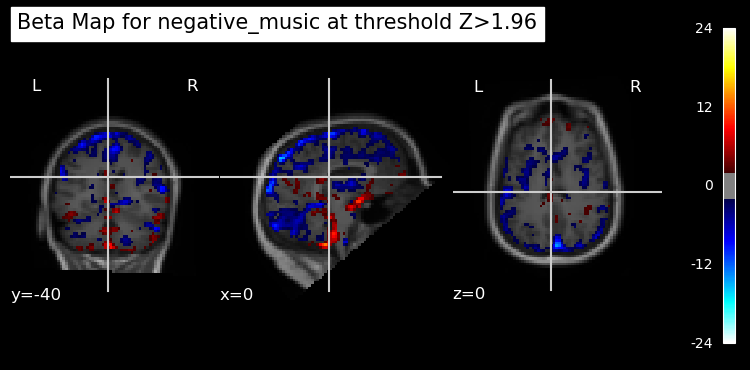

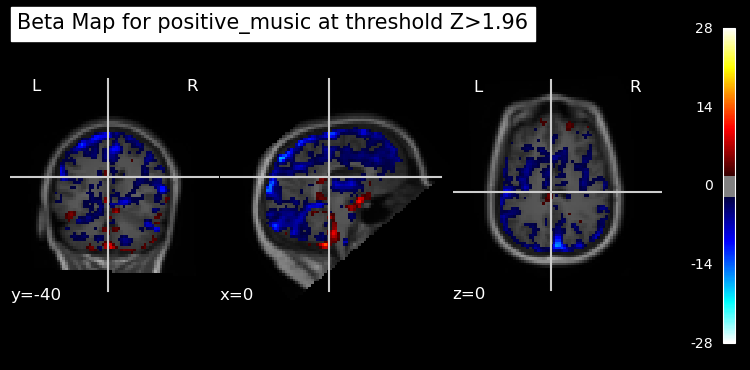

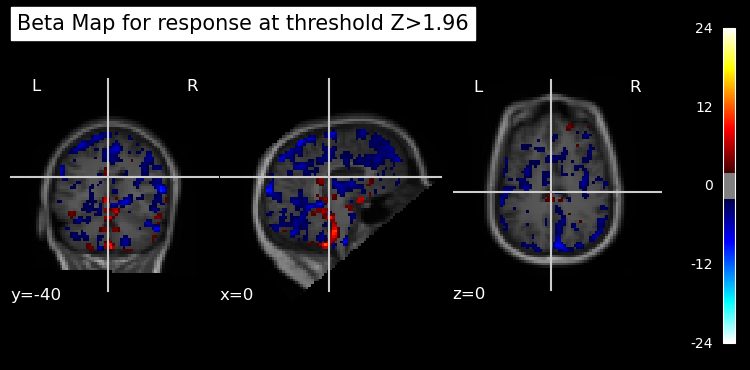

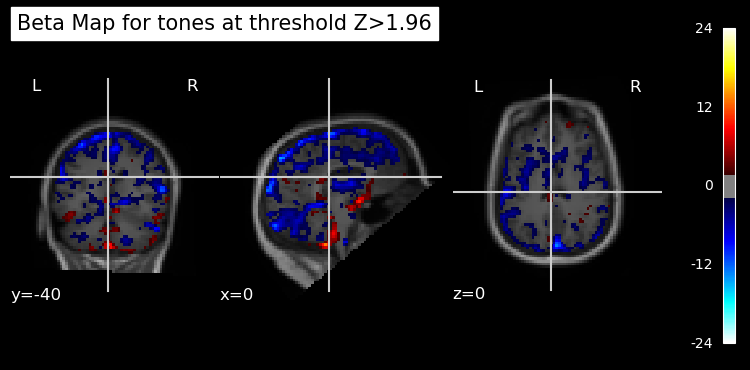

In [66]:
# Get regressor names from the design matrix
regressor_names = design_mat_regged.columns.tolist()  

regressor_of_interest = regressor_names[:4]
print(regressor_of_interest)
thresh = 1.96
# Background image can be set ot whatever nii.gz we wish to display the activation on
bg_path = op.join(coregistered_path, "coregistered_anatomical.nii.gz")
bg_img_anat = nib.load(bg_path)

# Loop over each regressor and plot its beta map
for regressor in regressor_of_interest:
    # Compute contrast for the specific regressor (=>beta map for that regressor)
    beta_map = fit_glm.compute_contrast(regressor, output_type='effect_size')
    
    # Plot the beta map
    display = plot_stat_map(beta_map, cut_coords = [0,-40,0], bg_img=bg_img_anat, title=f'Beta Map for {regressor} at threshold Z>{thresh}', threshold=thresh)#, output_file = op.join(bids_root, "Beta_map_{}.png".format(regressor)))
    plt.show()

## Part 1.4 Activation maps

### Part 1.4.A Building and plotting the contrast

<Axes: label='conditions'>

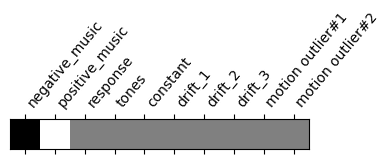

In [71]:
# Initializing contrast with values for "positive_music" and "negative_music" and padding with zeros for other columns
positive_minus_negative = np.array([-1, 1] + [0] * (design_mat_regged.shape[1] - 2))

# Plotting contrast matrix
plot_contrast_matrix(positive_minus_negative, design_matrix=design_mat_regged)#, output_file = op.join(bids_root, "Contrast_matrix.png"))

### Part 1.4.B Activation map of the beta coefficients of active minus rest

In [74]:
# Computing z_map
z_map = fit_glm.compute_contrast(positive_minus_negative,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

#### Plotting the Z map along the axial view

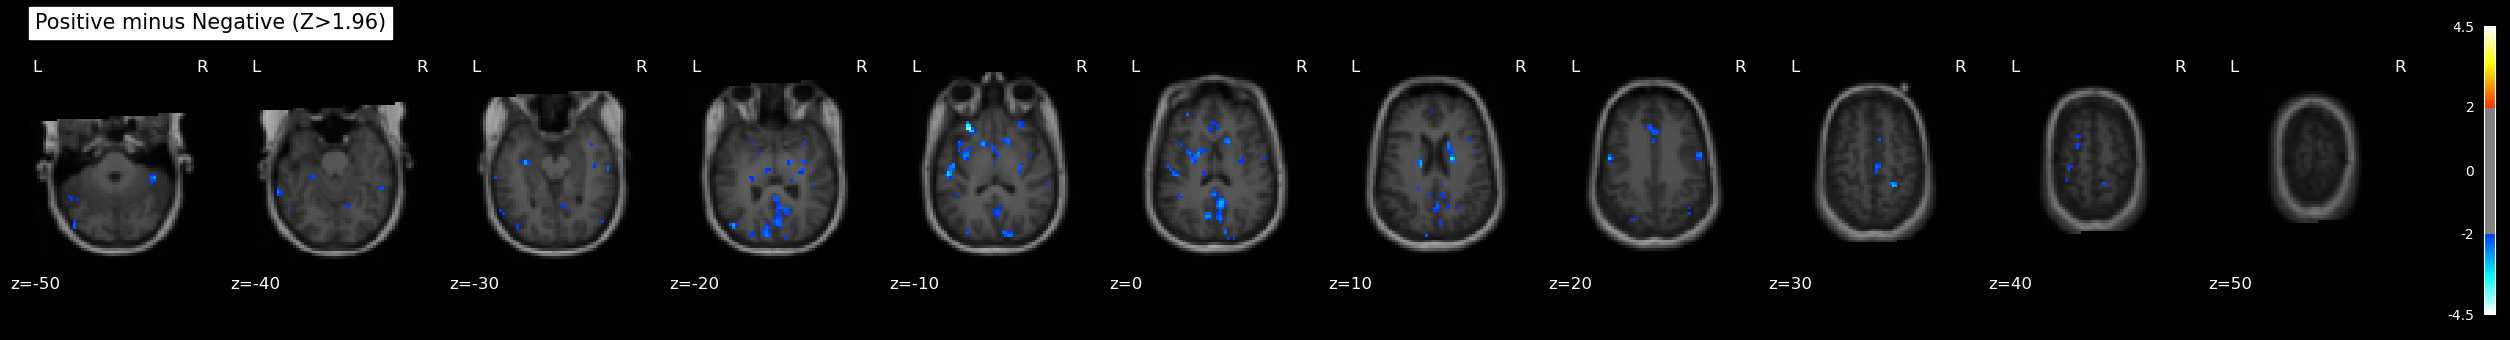

In [95]:
# Thresholding at 1.96
threshold = 1.96

plot_stat_map(z_map, bg_img=bg_img_anat, threshold=threshold,
              display_mode='z', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title=f'Positive minus Negative (Z>{threshold})')#, output_file = op.join(bids_root, "Activation_map_positivie-minus-negatuve.png"))
plt.show()

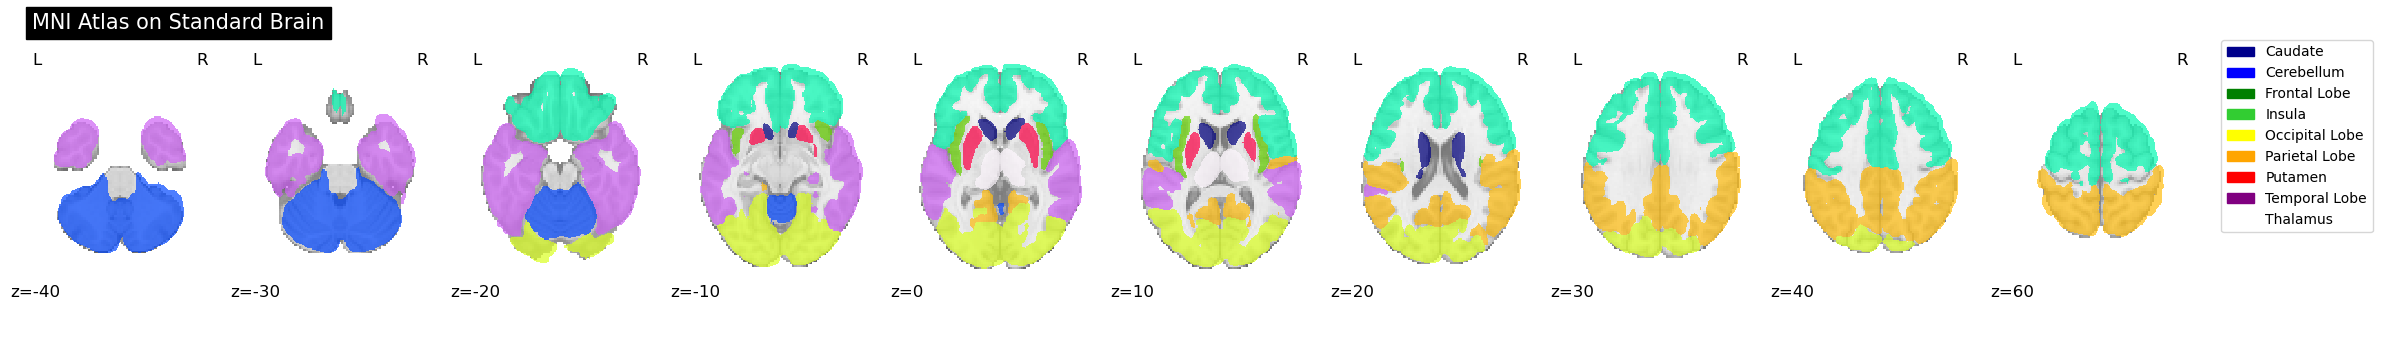

In [97]:
from nilearn import plotting
import nibabel as nib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Path to MNI atlas used in Week 1 exercices
mni_atlas_path = '/home/jovyan/Data/MNI-maxprob-thr25-1mm.nii.gz'
mni_atlas_img = nib.load(mni_atlas_path)

# Manually defining the colors and corresponding region names
region_colors = {
	'Caudate': '#00008B',   	# Dark blue
	'Cerebellum': 'blue',   	# Standard blue
	'Frontal Lobe': 'green',	# Standard green
	'Insula': '#32CD32',    	# Lime green hex
	'Occipital Lobe': 'yellow', # Standard yellow
	'Parietal Lobe': 'orange',  # Standard orange
	'Putamen': 'red',       	# Standard red
	'Temporal Lobe': 'purple',  # Standard purple
	'Thalamus': 'white'     	# Standard white
}

# Displaying the cuts of the 3D labeled atlas over the MNI standardized brain
display = plotting.plot_roi(
	mni_atlas_img,
	display_mode="z",
	cut_coords=[ -40, -30, -20, -10, 0, 10, 20, 30, 40, 60],
	title="MNI Atlas on Standard Brain"
)

# Adding a custom legend with region colors and names
patches = [mpatches.Patch(color=color, label=region) for region, color in region_colors.items()]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig(op.join(bids_root,"MNI_atlas.png"))
plotting.show()

Using the MNI-maxprob-thr25-1mm Atlas, we will go through each cut with significant contrast activations and explain potential regions involved:
We will also take into account that the the brain used here seems to be offset by about -10 in the z direction compared to the MNI standardized brain (i.e. Z=-10 for our brain corresponds roughly to Z=0 in the MNI brain cuts).

Z=-50,-40 and -30 show some small activation of the temporal lobe as well as the cerebellum
moving on to z=-20, we notice heavy activation of the cerebellum, a region invloved in emotional processing, as well as cognitive load and sensory processing.
for the z=-10 cut, we can see some activation of the parietal lobe, as well as heavy activation in the frontal lobe, a region heavily implied in emotional processing
in the Z=0 cut, we notice heavy activation of the parietal lobe, as well as some activaiton of the caudate as well as the putamen, both forming the striatum, a region involved in rhythm and movement, reward and emotion processing.
in the Z=10 cut, we see more heavy acivation of the parietal lobe as well as the caudate.
in the z=20 cut, we notice more activation of the frontal lobe and in Z=30 more frontal and parietal lobe activation.

Overall it appears that the Cerebellum, Parietal lobe, Frontal lobe, Putamen and Caudate are all heavily involved, implying very different actiation levels when the participant is exposed to positive music compared to negative music.
Strangely however we do not notice contrast activation in the temporal lobe, this could potentially be due to similar activation levels during positive and negative music periods, which cancel out when we substract the negative condition from the positive.

### Cluster size and False discovery rate 

/opt/conda/lib/python3.11/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 4.478919250975576. But, you have given threshold=inf.
  stat_img = threshold_img(
/opt/conda/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


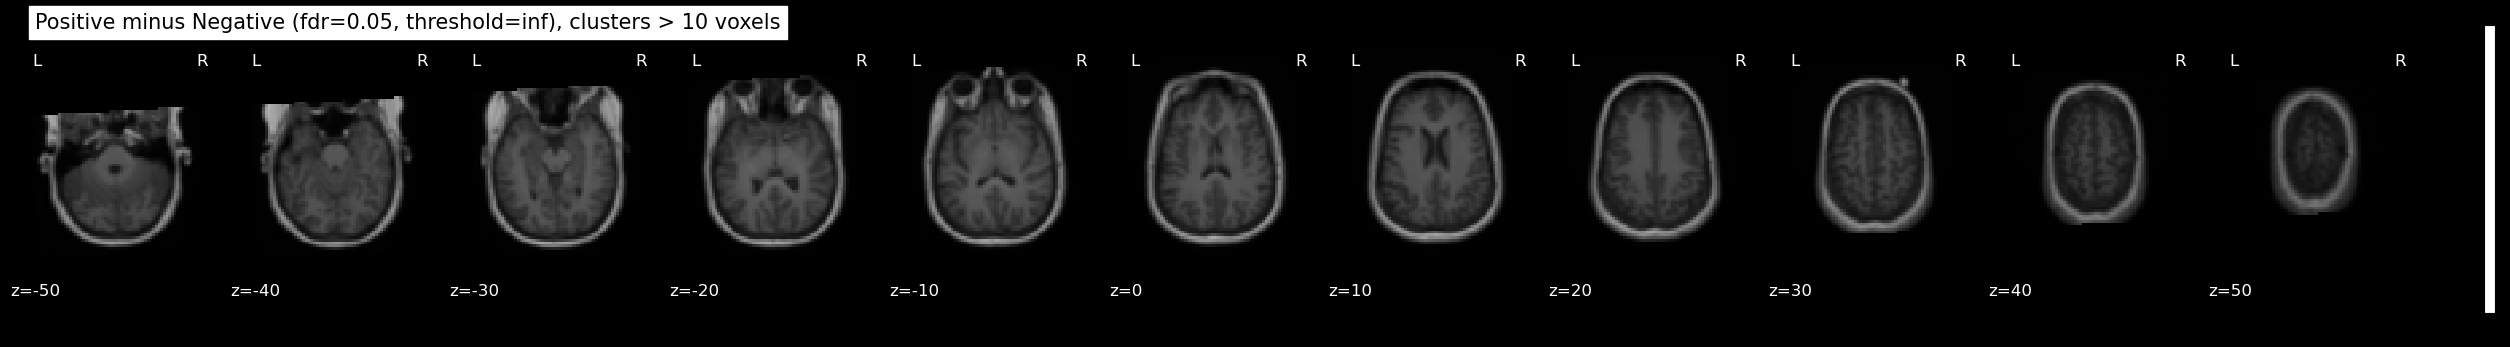

In [99]:
# Adjusting the test significance despite the multi-comparisons
cluster_size = 10 # The number of voxels for a cluster to be kept
fdr_rate = 0.05 # False discovery rate 

# FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

# Plotting
plot_stat_map(clean_map, bg_img=bg_img_anat, threshold=threshold,
              display_mode='z', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title='Positive minus Negative (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))#,  output_file = op.join(bids_root, "Activation_map_post_correction.png"))
plt.show()

# Part 2 - PCA

In [90]:
import os
import os.path as op
from tqdm.notebook import trange, tqdm
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from IPython.display import Image
from sklearn.decomposition import PCA

save_results = 'results/'
if not os.path.exists(save_results):
    os.makedirs(save_results)
    
%matplotlib inline

## Part 2.0 Loading and choosing the right data 

Before applying the PCA to the fMRI data, we need to preprocess it. However, the preprocessing steps have already been done above. Therefore, we can reuse the already obtained preprocessed runs. We decided to keep the smoothing step in order to improve the signal to noise ratio of the data that the PCA will be run on.

In [100]:
data_path = op.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco_smoothed-6mm.nii.gz')
img_anat = nib.load(op.join(preproc_root, 'sub-control01', 'anat','coregistered_anatomical.nii.gz'))
img = nib.load(data_path)
affine = img.affine
data = np.asanyarray(img.dataobj)
data.shape

(80, 80, 50, 315)

## Preprocessing

Since the PCA is meant to track the evolution of the data over time, the samples are timepoints and the voxels are seen as features. 

In [82]:
vol_shape = data.shape[0:3]
n_vols = data.shape[3]

num_zero_values_after = np.sum(data == 0)
print(f"Number of zero values after standardization: {num_zero_values_after}")

Number of zero values after standardization: 62761717


As we can see from the output of the previous cell, there is a great number of voxels with a null value. They correspond to the background, and were added at the end of the preprocessing step by applying a mask. In order to continue, we need to get rid of them since they are irrelevant for the PCA: they contain no data influenced by the experiment at hand.

In [83]:
# Removing background
slice_non_background = np.ones(vol_shape, dtype=bool) # intialize a mask to keep track of non-background voxels
samples = data[slice_non_background, :]
print('original shape:', samples.shape)

for vol in range(n_vols):
    slice_non_background &= (data[:, :, :, vol] != 0) # use AND with every voxel in every volume to update mask

samples = data[slice_non_background, :] ## shape should be (n_voxels, n_timepoints) for PCA
print('shape after removing background', samples.shape)

if np.any(samples == 0):
    print("Warning: There are still zero values in the samples array!")


original shape: (320000, 315)
shape after removing background (112268, 315)


Removing the spatial mean across timepoints from each timepoints. Calculates the mean spatial pattern and perform the substraction operation.

In [84]:
# Calculate the mean across columns
spatial_means = np.mean(samples, axis=1) # shape (1, n_timepoints)

# Row means copied n_vols times so that we substract for each timepoint the spatial mean
row_means = np.outer(spatial_means, np.ones(n_vols))

# Subtract the means for each row, put the result into X
X = samples - row_means

# Verify that the spatial mean behaves as expected after substraction
# Calculate the mean across time for each voxel to chek if its close to zero 
verification_means = np.mean(X, axis=-1)

# Print verification result
print("Verification (should be close to zero): \n", np.round(verification_means, decimals=4))

Verification (should be close to zero): 
 [-0. -0.  0. ...  0.  0. -0.]


As we can see from the output of the previous cell, the values of the row-wise mean of the X matrix are close to zero. This means that our centering worked. Indeed, by subtracting the mean for each voxel across all time points, we make the time series of each voxel have an average value of zero, which is what we see here. What is left is to check weather the X matrix has the right shape.

In [85]:
X.shape

(112268, 315)

Which is the case: it has the same shape as the samples matrix after the removal of the zero voxels.

## Part 2.1 Components extraction

Now we can move on to the extraction of components. In the next cell we run the PCA. There is no need to run it on the transpose of the X matrix, since it already has the right dimensions.

In [101]:
nb_components = 20 # Arbitrary number

pca = PCA(n_components=nb_components)

# Fit the PCA model to the data (where samples are voxels and features are time points)
pca.fit(X.T)

# Retrieve the principal components
components = pca.components_  # Shape (nb_components, n_timepoints)
explained_variance = pca.explained_variance_ratio_

print("Explained variance by each component:", explained_variance)
print("Components shape:", components.shape)

Explained variance by each component: [0.68291673 0.13580717 0.0393219  0.0142351  0.01178244 0.008478
 0.00705984 0.00655059 0.00494029 0.00472867 0.00413815 0.0038412
 0.00321213 0.00290459 0.00281639 0.00238626 0.00217035 0.00175547
 0.00165023 0.00144532]
Components shape: (20, 112268)


Now we must choose a number of components that will explain a sufficient amount of variance. We know that the bigger an eigenvalue is, the more variance it explains. Therefore, we will sort them and plot the sum of the explained variance as a funcion of the first considered eigenvalues.

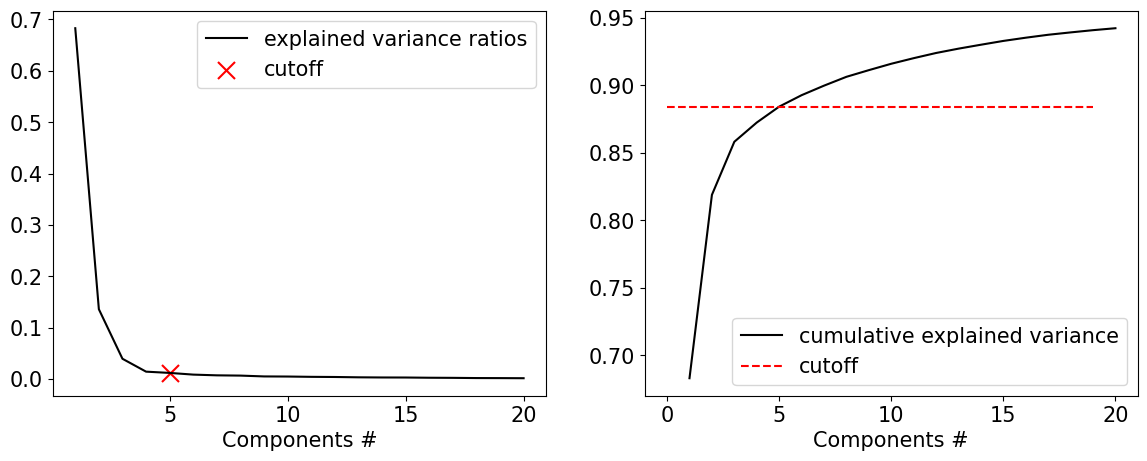

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ratios = pca.explained_variance_ratio_
cumulative_ratios = np.cumsum(pca.explained_variance_ratio_)
nb_clusters = 5

ax[0].plot(np.arange(1, len(ratios)+1), ratios, label='explained variance ratios', c='k')
ax[0].scatter([nb_clusters], [ratios[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax[1].plot(np.arange(1, len(cumulative_ratios)+1), cumulative_ratios, label='cumulative explained variance', c='k')
ax[1].hlines(y=cumulative_ratios[nb_clusters-1], xmin=0, xmax=len(ratios)-1, linestyle='--', color='r', label='cutoff')

for k in range(2):
    ax[k].set_xlabel('Components #', size=15)
    ax[k].legend(prop={'size':15})
    ax[k].tick_params(axis='both', which='major', labelsize=15)

fig.savefig(op.join(bids_root, "PCA_varianc_cutoff.png"))

From these graphs, we can see that keeping the first five components explains almost 90% of the total variance. Now, from these five components, we will reconstruct spatial volumes and overlay them onto anatomical data to visualise the parts of the brain that are the most influenced by the notes and songs heard during the fMRI runs.

In [88]:
# Initialize an empty list to store each spatial component as a 3D volume
pca_clusters = []

# For each component, reshape it back to the original spatial shape using the mask
for spatial_component in components:
    # Step 1: Initialize a 3D volume with the original shape, filled with zeros or NaN
    component_volume = np.zeros(vol_shape)  # Or use np.full(vol_shape, np.nan) for NaNs

    # Step 2: Place the values from the component back into the spatial volume
    component_volume[slice_non_background] = spatial_component

    # Step 3: Append the reshaped 3D volume to the list
    pca_clusters.append(component_volume)

# `pca_clusters` now contains reconstructed spatial volumes for each PCA component

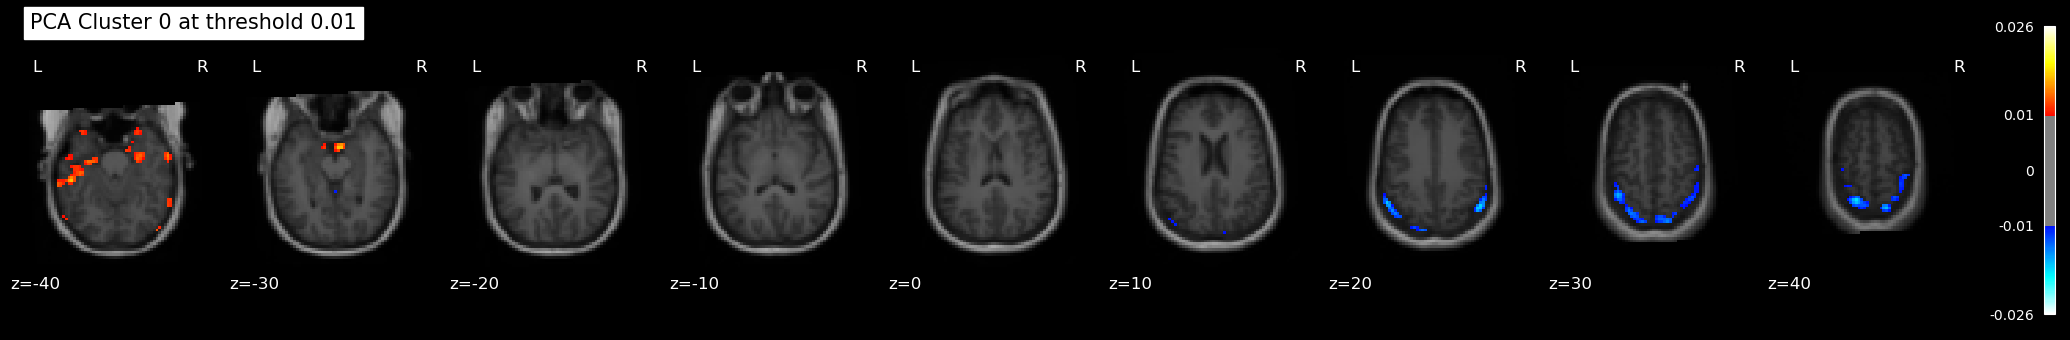

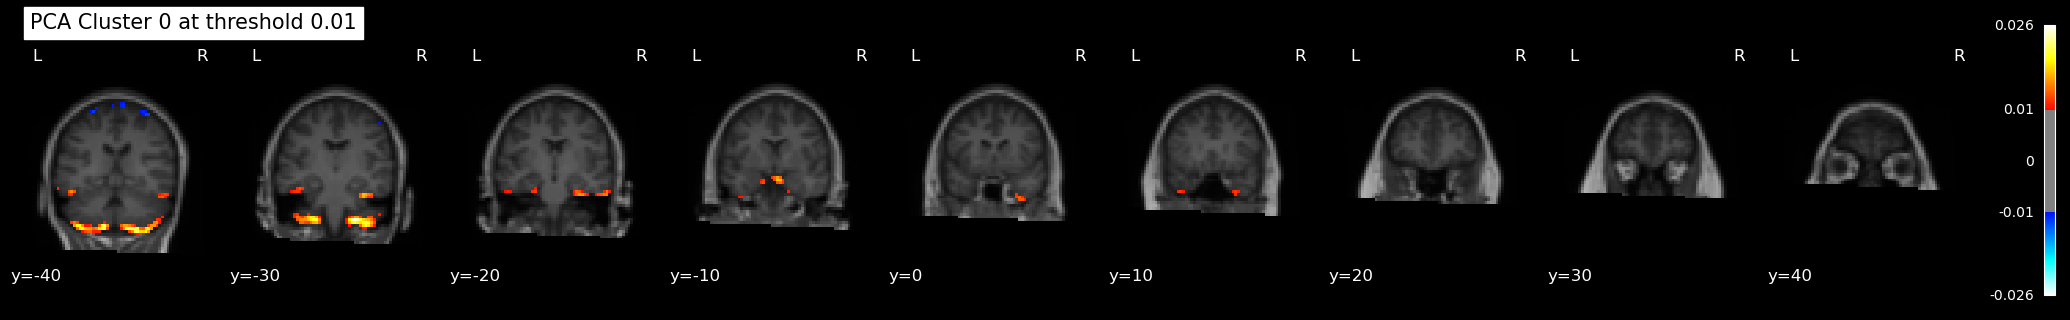

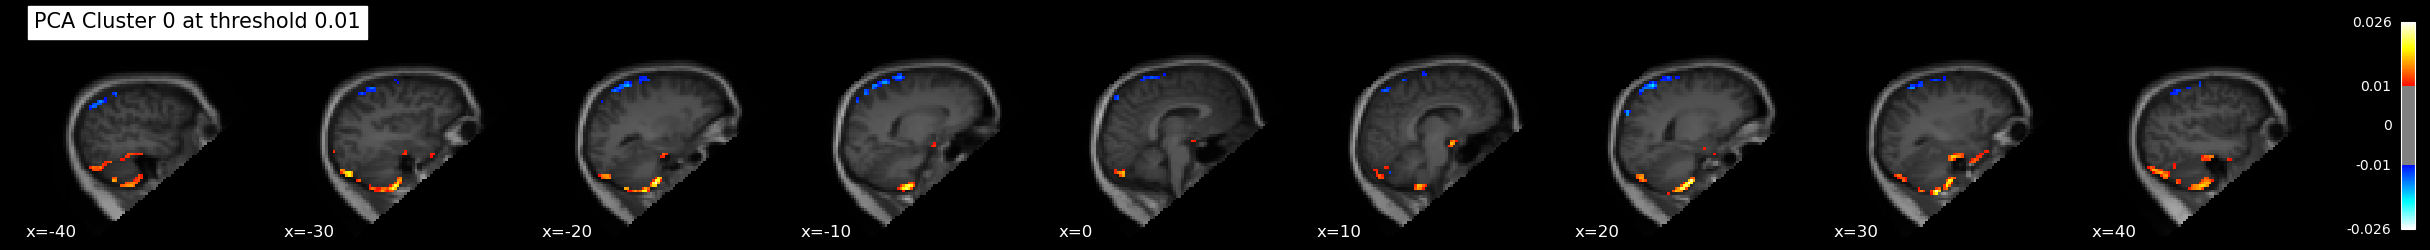

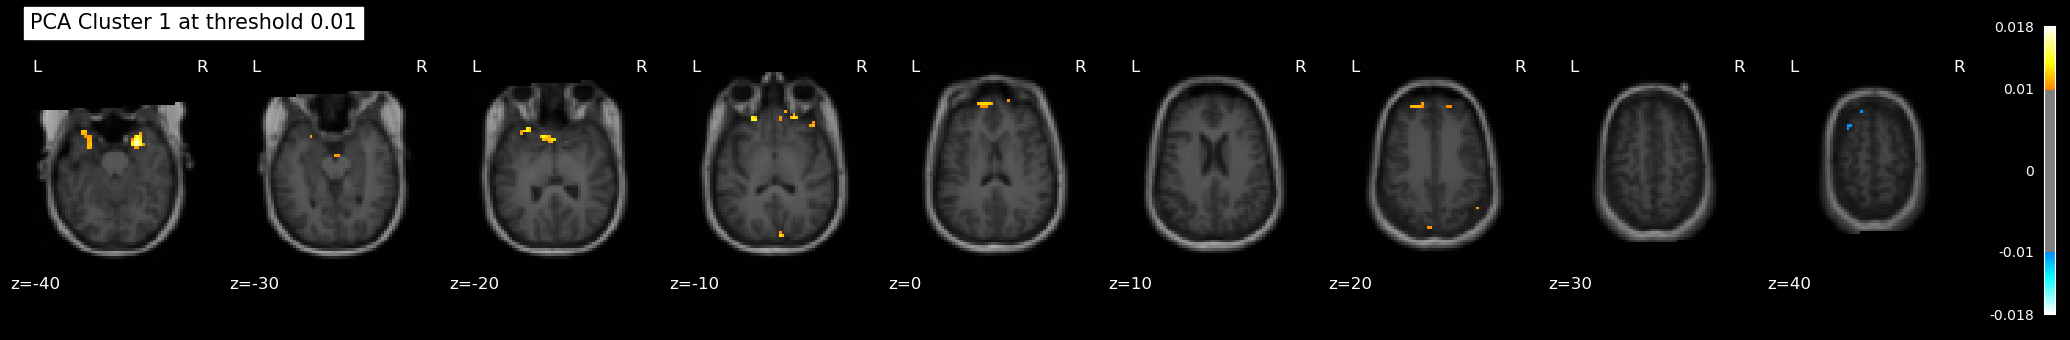

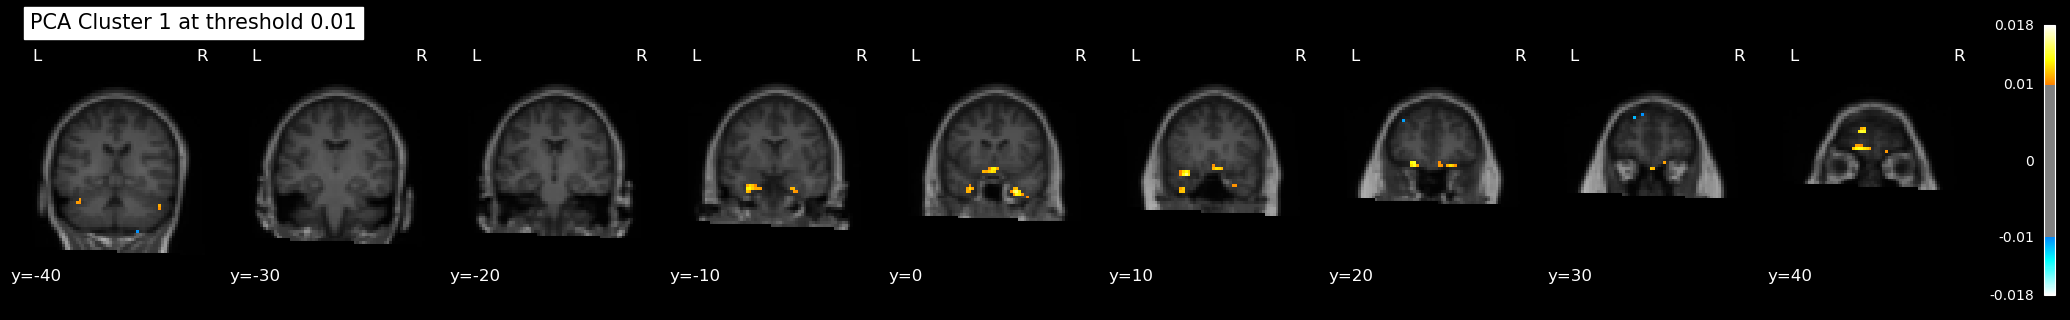

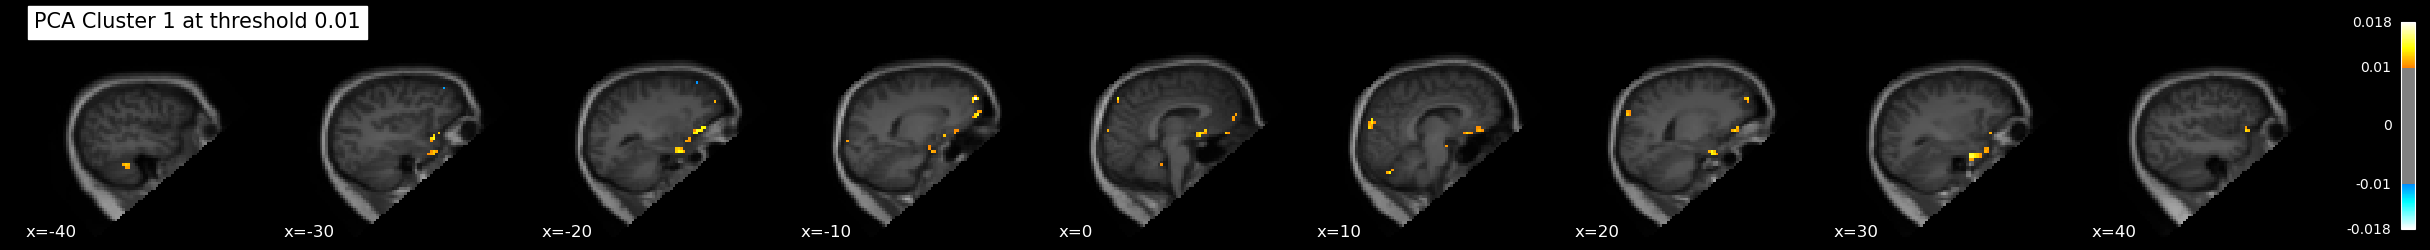

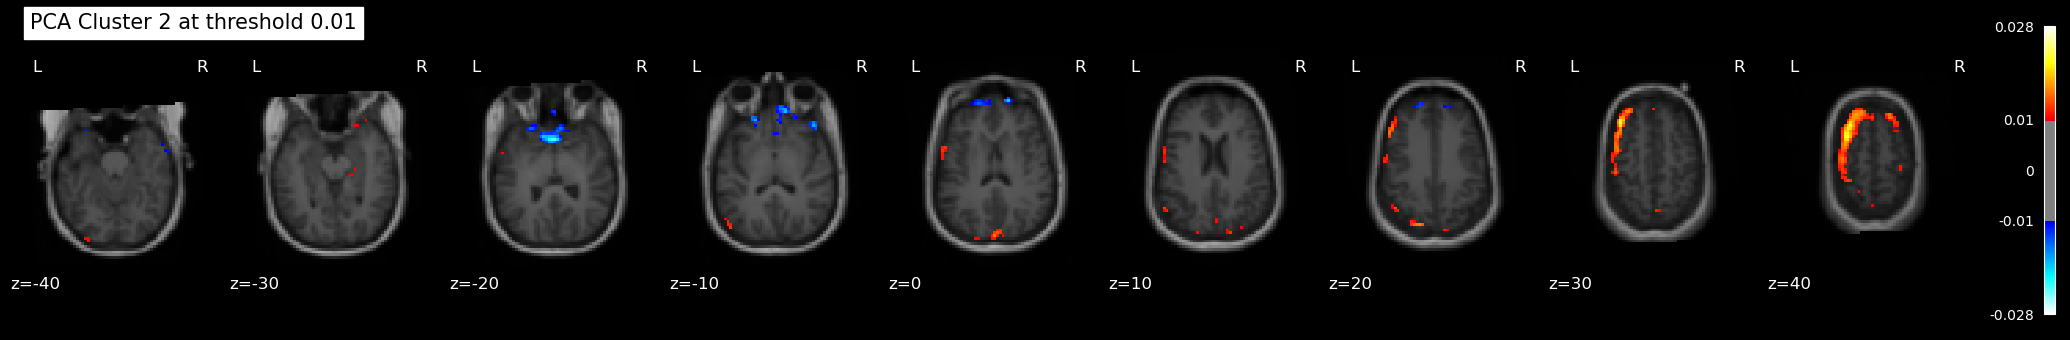

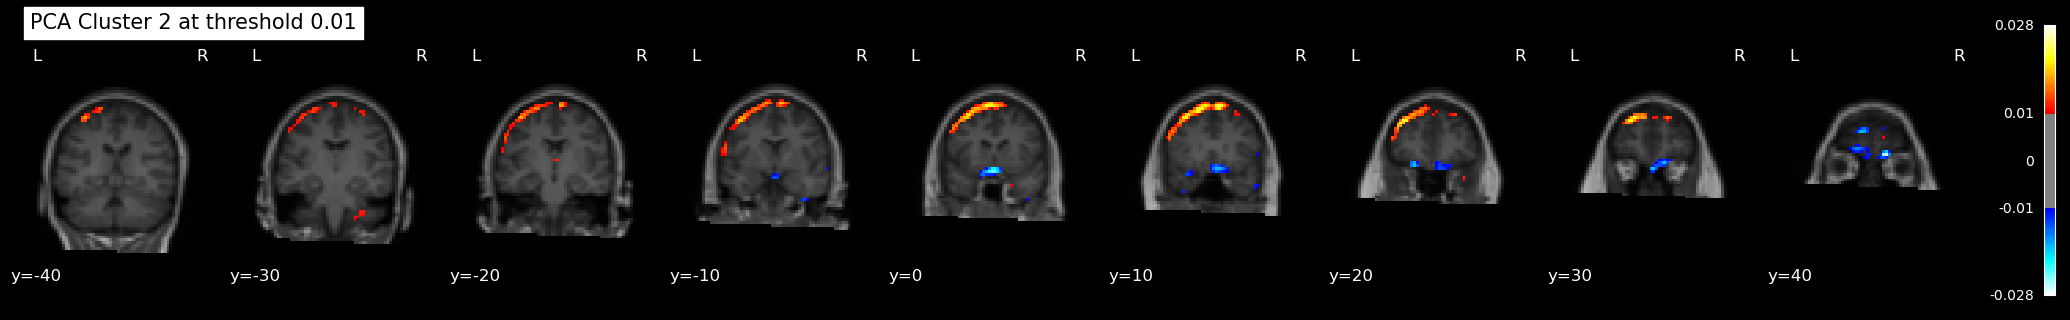

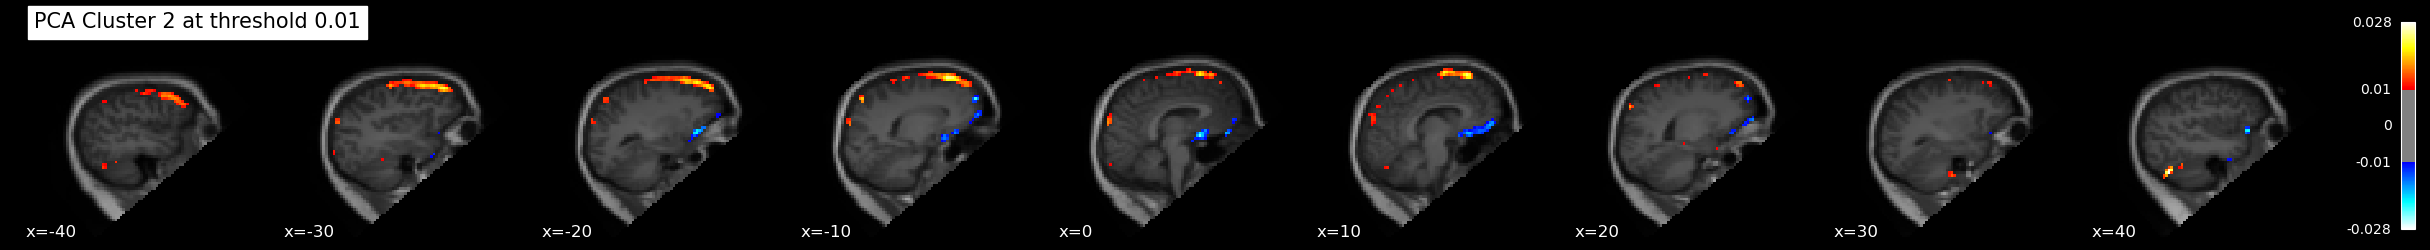

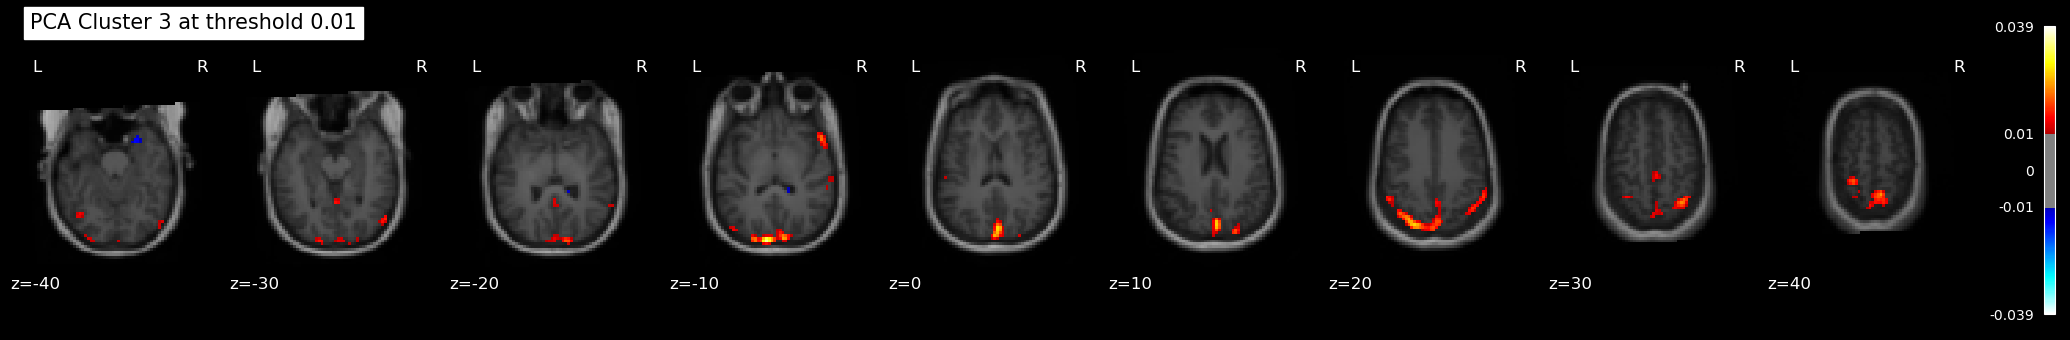

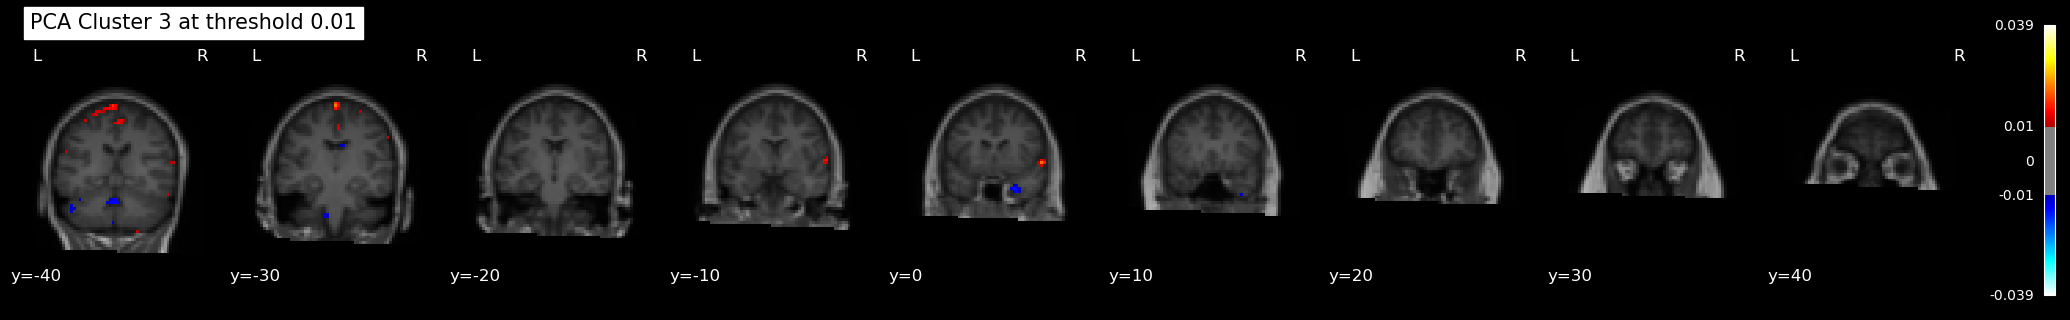

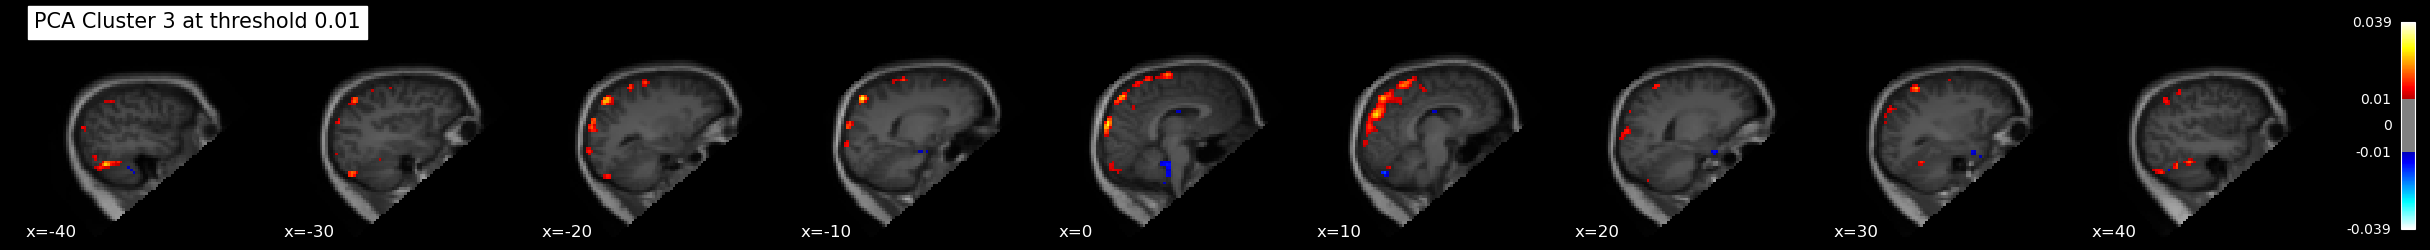

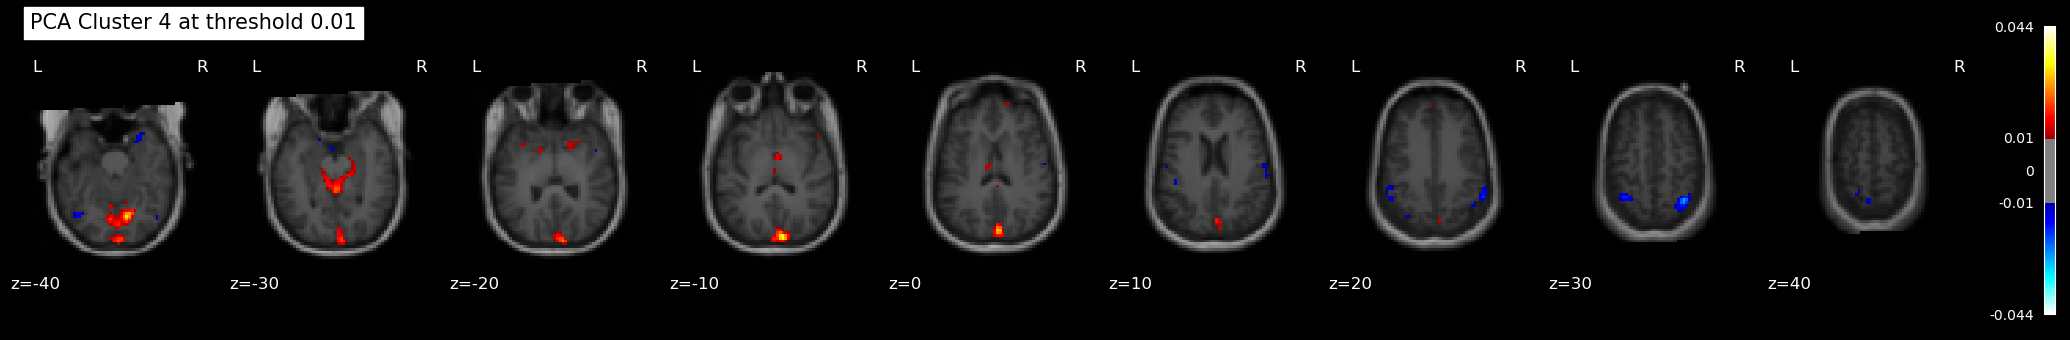

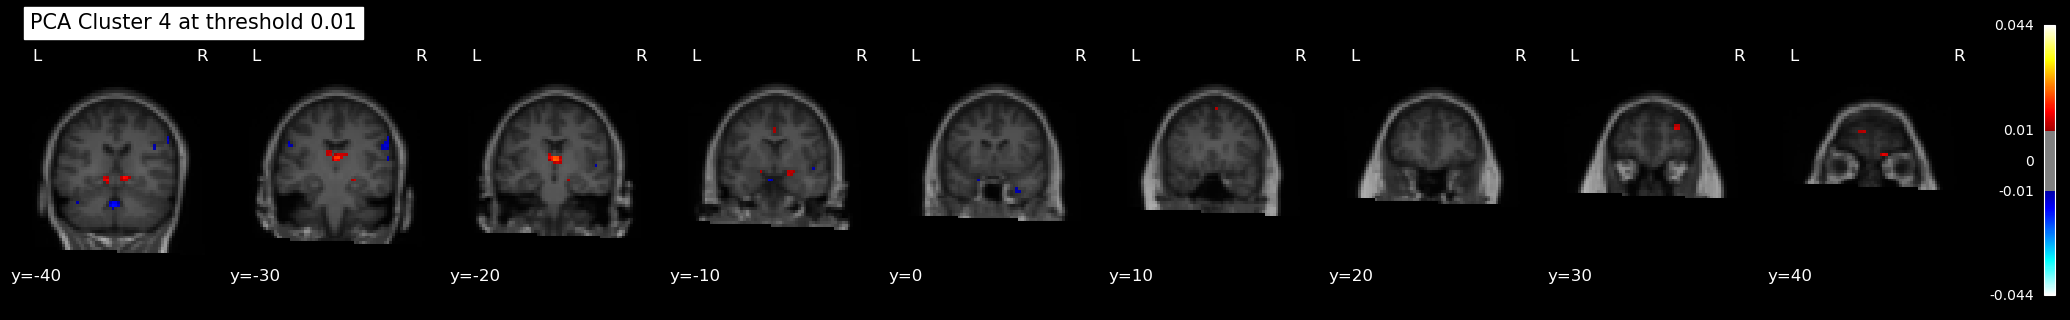

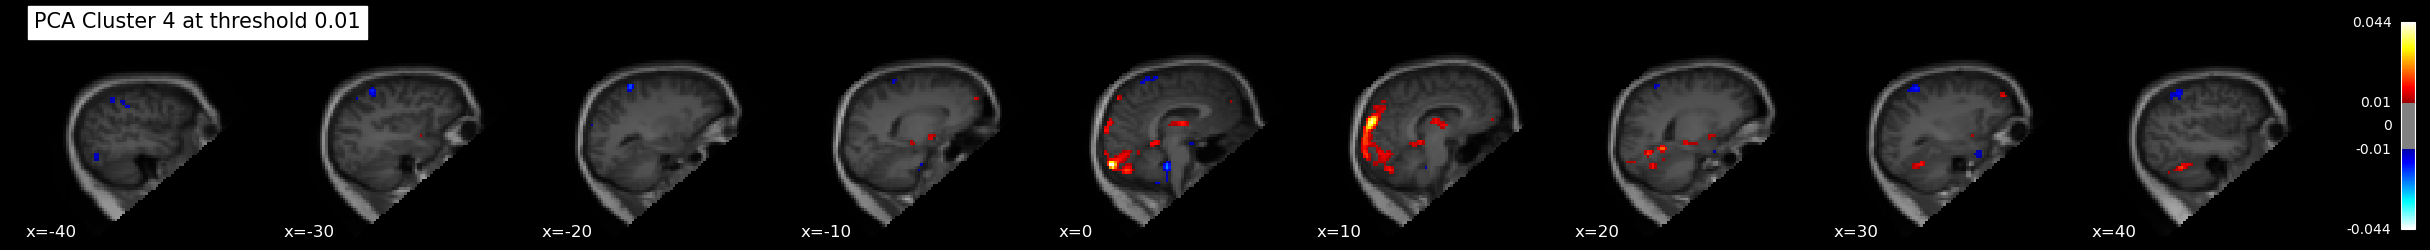

In [116]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(img_anat)
threshold = 0.01
for visual_idx in range(nb_clusters):
    plot_stat_map(nib.Nifti1Image(pca_clusters[visual_idx], affine), bg_img=mean_img_, threshold=threshold,
                   cut_coords=[-40, -30, -20, -10, 0, 10, 20, 30, 40], black_bg=True, display_mode = "z",
                  title=f'PCA Cluster {visual_idx} at threshold {threshold}')#, output_file = op.join(bids_root, "PCA_axial{}.png".format(visual_idx)))
    plot_stat_map(nib.Nifti1Image(pca_clusters[visual_idx], affine), bg_img=mean_img_, threshold=threshold,
                   cut_coords=[-40, -30, -20, -10, 0, 10, 20, 30, 40], black_bg=True, display_mode = "y",
                  title=f'PCA Cluster {visual_idx} at threshold {threshold}')#, output_file = op.join(bids_root, "PCA_coronal{}.png".format(visual_idx)))
    plot_stat_map(nib.Nifti1Image(pca_clusters[visual_idx], affine), bg_img=mean_img_, threshold=threshold,
                   cut_coords=[-40, -30, -20, -10, 0, 10, 20, 30, 40], black_bg=True, display_mode = "x",
                  title=f'PCA Cluster {visual_idx} at threshold {threshold}')#, output_file = op.join(bids_root, "PCA_sagital{}.png".format(visual_idx)))

plt.show()